# Rasters {#sec-rasters}

## Loading packages

First, we import several packages we will be working with:

* `glob`---for listing file paths,
* `matplotlib.pyplot`---for plotting a raster layer and a vector layer together, 
* `numpy`---for working with arrays,
* `geopandas`---for working with vector layers, and
* `rasterio`, `rasterio.plot`, `rasterio.mask`---for working with rasters,

as follows:

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask

In [2]:
#| echo: false

plt.rcParams['figure.figsize'] = (6, 6)

## What is `rasterio`?

Working with *rasters* in Python is not as well-organized around one dominant and comprehensive package, such as `geopandas` for vector layers. Instead, there are several packages providing alternative (subsets of) methods for working with rasters, and each of them may require working with further helper or extension packages for specific tasks. 

`rasterio`---which we use in this tutorial---is a well-established and widely-used Python package for working with rasters. `rasterio` makes raster data accessible in the form of `numpy` arrays associated with a "metadata" object, so that we can operate on them, then write back to new raster files. `rasterio`, like most raster processing software, is based on the [GDAL](https://gdal.org/) software. Compared to `geopandas` (@sec-vector-layers), the `rasterio` package will seem more "low-level". And, as mentioned above, it needs to be complemented with other packages for specific tasks, such the [`rasterstats`](https://pythonhosted.org/rasterstats/) package for zonal statistics. 

Alternatively, each of the packages [`rioxarray`](https://corteva.github.io/rioxarray/stable/), [`xarray-spatial`](https://xarray-spatial.org/), and [`geowombat`](https://geowombat.readthedocs.io/en/latest/index.html), were developed as "high-level" alternatives to `rasterio`, using an [`xarray`](https://docs.xarray.dev/en/stable/#)-based representation of rasters (compared to `rasterio`, which is `numpy`-based). These packages are higher-level, representing rasters in a single object with both data and metadata. They are, therefore, easier to work with, but less well-established than `rasterio` (and similarly not feature-complete). 


## Reading from file

The `rasterio` package works with the concept of a *file connection*, a pointer to a file on disk, with associated methods for reading from or writing to. A `rasterio` file connection to a raster file has two components: 

* The metadata (such as the dimensions, resolution, CRS, etc.) 
* A reference to the raster values (@fig-rasterio-structure)

The raster values are thus not immediately read into memory. Instead, whenever necessary, the values can be read, either all at once, or from a particular band, or from a "window", or at a particular resolution. The rationale is that the metadata are small (and often useful to examine on their own), while values are often very big. Therefore, it can be more practical to have control over which values to read, and when.  

![Raster (`rasterio`) structure](images/rasterio-structure.svg){#fig-rasterio-structure}

To create a file connection object to a raster file, we use the [`rasterio.open`](https://rasterio.readthedocs.io/en/stable/api/rasterio.html#rasterio.open) function. For example, here we create a file connection object named `src`, which refers to the `HLS.S30.T33UXU.2022200T095559.v2.0.B02.tiff` raster:

In [3]:
src = rasterio.open('data/hls/HLS.S30.T33UXU.2022200T095559.v2.0.B02.tiff')
src

<open DatasetReader name='data/hls/HLS.S30.T33UXU.2022200T095559.v2.0.B02.tiff' mode='r'>

This file is: 

* one of the four sample data files (`B02`=blue band, see @sec-stacking-raster-bands), 
* comprising a Landsat-8 and Sentinel-2 satellite-image based reflectance raster,
* from the [Harmonized Landsat Sentinel-2 (HLS) Surface Reflecance](https://lpdaac.usgs.gov/news/release-of-harmonized-landsat-and-sentinel-2-hls-version-20/) product, which provides global observations of the land every 2–3 days at 30-$m$ spatial resolution,
* from `2022-07-19`, 
* tile ID `T33UXU` (covering Poznan),
* downloaded from [EarthData Search](https://search.earthdata.nasa.gov/).

Note that the file connection specifies `mode='r'`, i.e., reading mode, which is the default of `rasterio.open`. When writing a raster file, we create a file connection (possibly to a not yet existing file) in writing mode (`mode='w'`) (@sec-stacking-raster-bands).

The raster metadata can be accessed through the `.src` property of the file connection. For example, from the following metadata object:

In [4]:
src.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -9999.0,
 'width': 3660,
 'height': 3660,
 'count': 1,
 'crs': CRS.from_epsg(32633),
 'transform': Affine(30.0, 0.0, 600000.0,
        0.0, -30.0, 5900040.0)}

we can learn that:

* Raster source type (`driver`) is GeoTIFF
* Raster data type (`dtype`) is 16-bit integer (`int16`), i.e., `-32768` to `32767`
* The value representing "No Data" (`nodata`) is `-9999` 
* Raster size (`width`, `height`) is $3,660\times3,660$ pixels
* The number of bands (`count`) is $1$
* Raster CRS (`crs`) is UTM Zone 33N (EPSG code `32633`)
* Raster origin and resolution (`transform`) are (`600000.0`,`5900040.0`) and (`30`,`30`), respectively

The raster values can be read using the [`.read`](https://rasterio.readthedocs.io/en/stable/api/rasterio.io.html#rasterio.io.DatasetReader.read) method. The default is to read all values (as mentioned above, there are many other options to read partial data):

In [5]:
r = src.read()
r

array([[[427, 440, 430, ..., 209, 328, 362],
        [449, 412, 439, ..., 315, 200, 233],
        [415, 364, 388, ..., 399, 306, 231],
        ...,
        [364, 393, 464, ..., 212, 280, 313],
        [164, 174, 173, ..., 236, 260, 265],
        [145, 143, 147, ..., 283, 286, 281]]], dtype=int16)

The resulting object `r` is an `ndarray` object (package `numpy`):

In [6]:
type(r)

numpy.ndarray

Note that array dimensions correspond to `(bands,rows,columns)`, in that order. In our case, `r` has `1` band, `3660` rows, and `3660` columns:

In [7]:
r.shape

(1, 3660, 3660)

The array stores the values using the same data type and the same precision as in the original file:

In [8]:
r.dtype

dtype('int16')

This means that the minimal amount of RAM is being used, which is an advantage of `rasterio` over other Python packages (e.g., `rioxarray` which imports all rasters as `float`), and programming languages such as R.

## Plotting (single-band) {#sec-plotting-single-band}

The `rasterio.plot.show` function (from the `rasterio.plot` "sub-package") can be used to plot a raster. This function can accept a file connection (see below), or an array (see @sec-plotting-rgb). 

For example, the following expression plots the raster from the `src` file connection, using reversed greyscale (`'Greys_r'`) colormap:

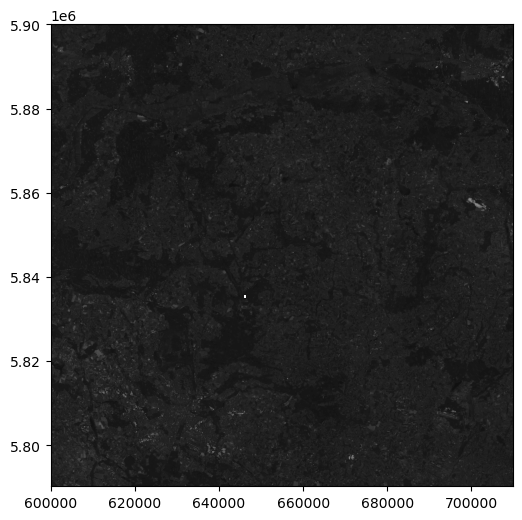

In [9]:
#| label: fig-single-band
#| fig-cap: 'Band 2 (Blue) band reflectance image of Poznan, based on HLS satellite data'

rasterio.plot.show(src, cmap='Greys_r');

## Stacking raster bands {#sec-stacking-raster-bands}

Remote sensing products, such as satellite images, are often distributed as a collection of single-band files, one file for each spectral band of the sensor. As specified in the HLS [product description](https://hls.gsfc.nasa.gov/products-description/overview/s30/), the file we just read (`B02`) represents *blue* reflectance. Overall, the following files are included in the sample data:

* `B02`---Blue
* `B03`---Green
* `B04`---Red
* `B08`---Near Infra Red (NIR)

In this section we will *stack* the four separate files into one multi-band raster file. As we will see, this involves reading the files in a `for` loop, and writing each band into a raster file connection created in *writing mode*. 

Using the [standard](https://docs.python.org/3/library/) Python package [`glob`](https://docs.python.org/3/library/glob.html), here is how we can obtain a `list` of all file paths matching a particular pattern:

In [10]:
files = glob.glob('data/hls/*.tiff')
files

['data/hls\\HLS.S30.T33UXU.2022200T095559.v2.0.B02.tiff',
 'data/hls\\HLS.S30.T33UXU.2022200T095559.v2.0.B03.tiff',
 'data/hls\\HLS.S30.T33UXU.2022200T095559.v2.0.B04.tiff',
 'data/hls\\HLS.S30.T33UXU.2022200T095559.v2.0.B08.tiff']

Typically satellite bands are ordered according to wavelength, from shortest (in our case, Blue) to longest (in our case, NIR). Since the latter matches alphabetical order, we can sort using the [.sort](https://docs.python.org/3/library/stdtypes.html#list.sort) method, as follows:

In [11]:
files.sort()
files

['data/hls\\HLS.S30.T33UXU.2022200T095559.v2.0.B02.tiff',
 'data/hls\\HLS.S30.T33UXU.2022200T095559.v2.0.B03.tiff',
 'data/hls\\HLS.S30.T33UXU.2022200T095559.v2.0.B04.tiff',
 'data/hls\\HLS.S30.T33UXU.2022200T095559.v2.0.B08.tiff']

Writing rasters with `rasterio` can be thought of as the reverse of reading (@fig-rasterio-structure). Namely, we need to pass a metadata object when creating a file connection, and then write array(s) of values into the file connection. 

To read the data from `files`, and write them into a new multi-band file, using `rasterio`, our strategy is as follows:

* Creating a metadata object for the new file
* Creating a file connection to a (non-existing) file with the given metadata in `'w'` mode
* For each file in `files`:
    * Reading the data into an `ndarray`
    * Writing the data into the corresponding band in the new file
* Closing the file connection

The metadata for the multi-band file is identical to the single-band metadata, with the exception of the `count` property (number of bands). Therefore, we don't need to create the metadata from scratch. Instead, we re-use the existing metadata object: 

In [14]:
meta = src.meta
meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -9999.0,
 'width': 3660,
 'height': 3660,
 'count': 1,
 'crs': CRS.from_epsg(32633),
 'transform': Affine(30.0, 0.0, 600000.0,
        0.0, -30.0, 5900040.0)}

while modifying band `count` according to the number of files: 

In [15]:
meta.update(count=len(files))
meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -9999.0,
 'width': 3660,
 'height': 3660,
 'count': 4,
 'crs': CRS.from_epsg(32633),
 'transform': Affine(30.0, 0.0, 600000.0,
        0.0, -30.0, 5900040.0)}

Now that we have the metadata object, we create a "destination" file connection, hereby named `dst`, in writing mode `'w'`. The new file is named `hls.tif`:

In [16]:
dst = rasterio.open('hls.tif', 'w', **meta)
dst

<open DatasetWriter name='hls.tif' mode='w'>

Next, we iterate over the files, each time reading the current band and writing it to the destination file:

In [17]:
for index, filename in enumerate(files, start=1):
    src = rasterio.open(filename)
    dst.write(src.read(1), index)
    src.close()

Finally, we close the file connection, to make sure that all data have been written:

In [18]:
dst.close()

Now, we create a file connection `src` to the newly created file to keep working with it. Examining the metadata shows that indeed it has four bands (`'count':4`):

In [19]:
src = rasterio.open('hls.tif')
src.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -9999.0,
 'width': 3660,
 'height': 3660,
 'count': 4,
 'crs': CRS.from_epsg(32633),
 'transform': Affine(30.0, 0.0, 600000.0,
        0.0, -30.0, 5900040.0)}

Using `.read` we can read the data from all (four) bands, as follows:

In [20]:
r = src.read()
r

array([[[ 427,  440,  430, ...,  209,  328,  362],
        [ 449,  412,  439, ...,  315,  200,  233],
        [ 415,  364,  388, ...,  399,  306,  231],
        ...,
        [ 364,  393,  464, ...,  212,  280,  313],
        [ 164,  174,  173, ...,  236,  260,  265],
        [ 145,  143,  147, ...,  283,  286,  281]],

       [[ 743,  765,  790, ...,  420,  607,  678],
        [ 740,  716,  770, ...,  556,  372,  444],
        [ 672,  620,  685, ...,  713,  575,  423],
        ...,
        [ 795,  872,  983, ...,  522,  571,  633],
        [ 420,  444,  440, ...,  545,  593,  640],
        [ 424,  415,  412, ...,  734,  746,  727]],

       [[1118, 1183, 1221, ...,  364,  634,  709],
        [1068, 1048, 1175, ...,  529,  274,  354],
        [ 932,  881, 1004, ...,  698,  470,  310],
        ...,
        [ 512,  564,  652, ...,  342,  497,  576],
        [ 283,  293,  278, ...,  366,  398,  413],
        [ 226,  229,  239, ...,  465,  445,  457]],

       [[1985, 2003, 2106, ..., 2732,

`r` is now a three-dimensional `ndarray` with *four* bands: 

In [21]:
r.shape

(4, 3660, 3660)

When opened in QGIS, with bands 3-2-1 mapped to Red-Green-Blue, the `hls.tif` raster appears as shown in @fig-qgis-exported-raster.

![Exported raster file `hls.tif` viewed in QGIS](images/qgis_exported_raster.png){#fig-qgis-exported-raster}

## Data types

As shown above, `numpy` arrays are also associated with specific data types (all array values are of the same type). These correspond to raster file data types.
Commonly used data types in `numpy` are summarized in @tbl-numpy-types. As you can see, there are many varieties of numeric types in `numpy`. This may seem confusing, compared to basic Python or other programming languages such as R, which have just one data type for integer and one for float. However, keep in mind that the purpose of having many specific data types is conserving memory and making calculations more efficient.

| Data type | Description |
|---|--------------|
| `bool_` | Boolean (`True` or `False`) stored as a byte
| `int_` | Platform-dependent default integer type (normally `int64` or `int32`)
| `int8` | Integer in a single byte (`-128` to `127`)
| `int16` | Integer in 16 bits (`-32768` to `32767`)
| `int32` | Integer in 32 bits (`-2147483648` to `2147483647`)
| `int64` | Integer in 64 bits (`-9223372036854775808` to `9223372036854775807`)
| `uint8` | Unsigned integer (`0` to `255`)
| `uint16` | Unsigned integer (`0` to `65535`)
| `uint32` | Unsigned integer (`0` to `4294967295`)
| `uint64` | Unsigned integer (`0` to `18446744073709551615`)
| `float_` | Default float type, shorthand for `float64`
| `float16` | Half-precision (16 bit) float (`-65504` to `65504`)
| `float32` | Single-precision (32 bit) float (`1e-38` to `1e38`)
| `float64` | Double-precision (64 bit) float (`1e-308` to `1e308`)

: `ndarray` (package `numpy`) data types {#tbl-numpy-types}

For example, the HLS image we are working with is stored in the `int16` data type. Accordingly, when reading the data into RAM, the resulting array is of type `int16`:

In [22]:
r.dtype

dtype('int16')

According to the product [user guide](https://lpdaac.usgs.gov/documents/1326/HLS_User_Guide_V2.pdf), the HLS raster values: 

* need to be rescaled by a factor of `0.0001`, and
* contain `-9999` values representing "No Data".

*Rescaling* is common practice in remote sensing product packaging.  The rationale of rescaling is:

* The raster is stored in files using `int` data types, which takes less memory
* It's up to the user to rescale the values back to the valid range in "real" units, whenever they need to, which requires switching to `float` representation, thus consuming more memory

*"No Data"* representation is important for `int` rasters, since (due to computer memory constraints, and unlike `float` rasters) `int` rasters cannot contain "native" "No Data" values. Instead, a specific integer value (e.g., `-9999`) is used as a "No Data" flag:

In [23]:
src.nodata

-9999.0

When reading an `int` raster into memory, again, it is up to the user to choose how to deal with the specific "No Data" flag. Ignoring it, however, will lead to wrong results, where the "No Data" pixels are treated as valid raster values:

In [24]:
r[r == src.nodata]  ## i.e., r[r == -9999]

array([-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,
       -9999, -9999, -9999, -9999, -9999, -9999, -9999], dtype=int16)

Note that, technically, we've just used ["boolean array indexing"](https://numpy.org/doc/stable/user/basics.indexing.html#boolean-array-indexing), where a boolean array is used to subset a given array.

## Changing the data type {#sec-changing-data-type}

Going back to the 4-band HLS reflectance raster, in practice, the following pre-processing steps are required:

* transforming `r` to a `float` data type (this section),
* replacing the value `-9999` with the native "No Data" value (`np.nan`) (@sec-reclassify)
* rescaling all values by a factor of `0.0001` (@sec-raster-algebra)
* truncating values which are beyond the valid range (@sec-truncating-to-valid-range)

To transform an `ndarray` to a different data type, we use the [`.astype`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.astype.html) method. The recommended approach is to use the platform-standard `float` data type, specified as `np.float_` (@tbl-numpy-types), or simply `float`, typically resolving to `np.float64`:

In [25]:
r = r.astype(np.float_)
r

array([[[ 427.,  440.,  430., ...,  209.,  328.,  362.],
        [ 449.,  412.,  439., ...,  315.,  200.,  233.],
        [ 415.,  364.,  388., ...,  399.,  306.,  231.],
        ...,
        [ 364.,  393.,  464., ...,  212.,  280.,  313.],
        [ 164.,  174.,  173., ...,  236.,  260.,  265.],
        [ 145.,  143.,  147., ...,  283.,  286.,  281.]],

       [[ 743.,  765.,  790., ...,  420.,  607.,  678.],
        [ 740.,  716.,  770., ...,  556.,  372.,  444.],
        [ 672.,  620.,  685., ...,  713.,  575.,  423.],
        ...,
        [ 795.,  872.,  983., ...,  522.,  571.,  633.],
        [ 420.,  444.,  440., ...,  545.,  593.,  640.],
        [ 424.,  415.,  412., ...,  734.,  746.,  727.]],

       [[1118., 1183., 1221., ...,  364.,  634.,  709.],
        [1068., 1048., 1175., ...,  529.,  274.,  354.],
        [ 932.,  881., 1004., ...,  698.,  470.,  310.],
        ...,
        [ 512.,  564.,  652., ...,  342.,  497.,  576.],
        [ 283.,  293.,  278., ...,  366.,  39

We can use `.dtype` to see that, indeed, the data type has changed to `np.float64`:

In [26]:
r.dtype

dtype('float64')

## Reclassify {#sec-reclassify}

Next, we replace the value `-9999` with the native [`np.nan`](https://numpy.org/doc/stable/user/misc.html#ieee-754-floating-point-special-values) value (which is possible now that the array is of type `float`). This ensures that all subsequent arithmetic calculations, such as raster algebra (@sec-raster-algebra), actually "ignore" invalid pixels:

In [27]:
r[r == src.nodata] = np.nan
r

array([[[ 427.,  440.,  430., ...,  209.,  328.,  362.],
        [ 449.,  412.,  439., ...,  315.,  200.,  233.],
        [ 415.,  364.,  388., ...,  399.,  306.,  231.],
        ...,
        [ 364.,  393.,  464., ...,  212.,  280.,  313.],
        [ 164.,  174.,  173., ...,  236.,  260.,  265.],
        [ 145.,  143.,  147., ...,  283.,  286.,  281.]],

       [[ 743.,  765.,  790., ...,  420.,  607.,  678.],
        [ 740.,  716.,  770., ...,  556.,  372.,  444.],
        [ 672.,  620.,  685., ...,  713.,  575.,  423.],
        ...,
        [ 795.,  872.,  983., ...,  522.,  571.,  633.],
        [ 420.,  444.,  440., ...,  545.,  593.,  640.],
        [ 424.,  415.,  412., ...,  734.,  746.,  727.]],

       [[1118., 1183., 1221., ...,  364.,  634.,  709.],
        [1068., 1048., 1175., ...,  529.,  274.,  354.],
        [ 932.,  881., 1004., ...,  698.,  470.,  310.],
        ...,
        [ 512.,  564.,  652., ...,  342.,  497.,  576.],
        [ 283.,  293.,  278., ...,  366.,  39

This is an example of *reclassifying* raster values, where we convert all pixel values in a given range to a uniform value. Technically, this is another example of "boolean array indexing" (@sec-changing-data-type), only that we've also assigned a new value into the subset.

Here we demonstrate that the array no longer contains `-9999` values:

In [28]:
r[r == src.nodata]

array([], dtype=float64)

## Raster algebra {#sec-raster-algebra}

The next pre-processing step is rescaling. Array rescaling is an example of a "vectorized" operation, automatically carried out element-by-element on all array values, at once. In `numpy` terminology, this is known as ["universal functions"](https://numpy.org/doc/stable/user/basics.ufuncs.html).

For example, the following expression multiplies all values of array `r` by the scaling factor of `0.0001`:

In [29]:
r = r * 0.0001
r

array([[[0.0427, 0.044 , 0.043 , ..., 0.0209, 0.0328, 0.0362],
        [0.0449, 0.0412, 0.0439, ..., 0.0315, 0.02  , 0.0233],
        [0.0415, 0.0364, 0.0388, ..., 0.0399, 0.0306, 0.0231],
        ...,
        [0.0364, 0.0393, 0.0464, ..., 0.0212, 0.028 , 0.0313],
        [0.0164, 0.0174, 0.0173, ..., 0.0236, 0.026 , 0.0265],
        [0.0145, 0.0143, 0.0147, ..., 0.0283, 0.0286, 0.0281]],

       [[0.0743, 0.0765, 0.079 , ..., 0.042 , 0.0607, 0.0678],
        [0.074 , 0.0716, 0.077 , ..., 0.0556, 0.0372, 0.0444],
        [0.0672, 0.062 , 0.0685, ..., 0.0713, 0.0575, 0.0423],
        ...,
        [0.0795, 0.0872, 0.0983, ..., 0.0522, 0.0571, 0.0633],
        [0.042 , 0.0444, 0.044 , ..., 0.0545, 0.0593, 0.064 ],
        [0.0424, 0.0415, 0.0412, ..., 0.0734, 0.0746, 0.0727]],

       [[0.1118, 0.1183, 0.1221, ..., 0.0364, 0.0634, 0.0709],
        [0.1068, 0.1048, 0.1175, ..., 0.0529, 0.0274, 0.0354],
        [0.0932, 0.0881, 0.1004, ..., 0.0698, 0.047 , 0.031 ],
        ...,
        [0.0

## Truncating to valid range {#sec-truncating-to-valid-range}

Since [reflectance](https://en.wikipedia.org/wiki/Reflectance) values are proportional, the valid range is between `0` (zero reflectance, i.e., completely dark) to `1` (complete reflectance, i.e., completely bright). Due to specific image acquisition and processing issues, the actual values may be beyond the valid range, in which case we may want to truncate them. 

In our example, indeed the range of values in `r` goes beyong `0`--`1`. We can use the [`np.nanmin`](`np.nanmin`) and [`np.nanmax`](https://numpy.org/doc/stable/reference/generated/numpy.nanmax.html) to obtain the minimum and maximum values in an array, respectively, excluding `np.nan`:

In [30]:
np.nanmin(r), np.nanmax(r)

(-0.0339, 1.1088)

Again, we can use "boolean array indexing" to "truncate" array values according to the valid range:

In [31]:
r[r < 0] = 0
r[r > 1] = 1
r

array([[[0.0427, 0.044 , 0.043 , ..., 0.0209, 0.0328, 0.0362],
        [0.0449, 0.0412, 0.0439, ..., 0.0315, 0.02  , 0.0233],
        [0.0415, 0.0364, 0.0388, ..., 0.0399, 0.0306, 0.0231],
        ...,
        [0.0364, 0.0393, 0.0464, ..., 0.0212, 0.028 , 0.0313],
        [0.0164, 0.0174, 0.0173, ..., 0.0236, 0.026 , 0.0265],
        [0.0145, 0.0143, 0.0147, ..., 0.0283, 0.0286, 0.0281]],

       [[0.0743, 0.0765, 0.079 , ..., 0.042 , 0.0607, 0.0678],
        [0.074 , 0.0716, 0.077 , ..., 0.0556, 0.0372, 0.0444],
        [0.0672, 0.062 , 0.0685, ..., 0.0713, 0.0575, 0.0423],
        ...,
        [0.0795, 0.0872, 0.0983, ..., 0.0522, 0.0571, 0.0633],
        [0.042 , 0.0444, 0.044 , ..., 0.0545, 0.0593, 0.064 ],
        [0.0424, 0.0415, 0.0412, ..., 0.0734, 0.0746, 0.0727]],

       [[0.1118, 0.1183, 0.1221, ..., 0.0364, 0.0634, 0.0709],
        [0.1068, 0.1048, 0.1175, ..., 0.0529, 0.0274, 0.0354],
        [0.0932, 0.0881, 0.1004, ..., 0.0698, 0.047 , 0.031 ],
        ...,
        [0.0

Here we demonstrate that the range is now between `0` and `1`:

In [32]:
np.nanmin(r), np.nanmax(r)

(0.0, 1.0)

## Subsetting w/ indices

We can get a subset of array values using numeric indices, using an expression such as `r[bands,rows,columns]`. Each of the indices can be: 

* an individual numeric value, e.g., `0` for the 1^st^ element, or
* a `list`, e.g., `[0,2]` for 1^st^ and 3^rd^ elements, or
* a slice, e.g., `0:3`, or `:3`, for 1^st^ (inclusive) through 4^th^ (exclusive) elements.

The `:` symbol implies *all elements*. 

For example, here is how we can subset `r` bands 1-3, all rows and all columns:

In [33]:
r[:3, :, :]

array([[[0.0427, 0.044 , 0.043 , ..., 0.0209, 0.0328, 0.0362],
        [0.0449, 0.0412, 0.0439, ..., 0.0315, 0.02  , 0.0233],
        [0.0415, 0.0364, 0.0388, ..., 0.0399, 0.0306, 0.0231],
        ...,
        [0.0364, 0.0393, 0.0464, ..., 0.0212, 0.028 , 0.0313],
        [0.0164, 0.0174, 0.0173, ..., 0.0236, 0.026 , 0.0265],
        [0.0145, 0.0143, 0.0147, ..., 0.0283, 0.0286, 0.0281]],

       [[0.0743, 0.0765, 0.079 , ..., 0.042 , 0.0607, 0.0678],
        [0.074 , 0.0716, 0.077 , ..., 0.0556, 0.0372, 0.0444],
        [0.0672, 0.062 , 0.0685, ..., 0.0713, 0.0575, 0.0423],
        ...,
        [0.0795, 0.0872, 0.0983, ..., 0.0522, 0.0571, 0.0633],
        [0.042 , 0.0444, 0.044 , ..., 0.0545, 0.0593, 0.064 ],
        [0.0424, 0.0415, 0.0412, ..., 0.0734, 0.0746, 0.0727]],

       [[0.1118, 0.1183, 0.1221, ..., 0.0364, 0.0634, 0.0709],
        [0.1068, 0.1048, 0.1175, ..., 0.0529, 0.0274, 0.0354],
        [0.0932, 0.0881, 0.1004, ..., 0.0698, 0.047 , 0.031 ],
        ...,
        [0.0

In [34]:
r[:3, :, :].shape

(3, 3660, 3660)

The last `:` indices can be omitted, therefore this gives the same result:

In [35]:
r[:3].shape

(3, 3660, 3660)

## Plotting (RGB) {#sec-plotting-rgb}

The `rasterio.plot.show` function automatically assumes that the first three bands refer to RGB, with range `0`-`255` (for `int`) or `0`-`1` (for `float`). Otherwise, we can rescale the values and/or rearrange the bands.

In our example, raster values are `float` and in the `0`-`1` range (as expected). However, the bands in reverse order than expected (BGR). To reverse the order of bands we can use the `::-1` slice:

In [36]:
r[:3][::-1]

array([[[0.1118, 0.1183, 0.1221, ..., 0.0364, 0.0634, 0.0709],
        [0.1068, 0.1048, 0.1175, ..., 0.0529, 0.0274, 0.0354],
        [0.0932, 0.0881, 0.1004, ..., 0.0698, 0.047 , 0.031 ],
        ...,
        [0.0512, 0.0564, 0.0652, ..., 0.0342, 0.0497, 0.0576],
        [0.0283, 0.0293, 0.0278, ..., 0.0366, 0.0398, 0.0413],
        [0.0226, 0.0229, 0.0239, ..., 0.0465, 0.0445, 0.0457]],

       [[0.0743, 0.0765, 0.079 , ..., 0.042 , 0.0607, 0.0678],
        [0.074 , 0.0716, 0.077 , ..., 0.0556, 0.0372, 0.0444],
        [0.0672, 0.062 , 0.0685, ..., 0.0713, 0.0575, 0.0423],
        ...,
        [0.0795, 0.0872, 0.0983, ..., 0.0522, 0.0571, 0.0633],
        [0.042 , 0.0444, 0.044 , ..., 0.0545, 0.0593, 0.064 ],
        [0.0424, 0.0415, 0.0412, ..., 0.0734, 0.0746, 0.0727]],

       [[0.0427, 0.044 , 0.043 , ..., 0.0209, 0.0328, 0.0362],
        [0.0449, 0.0412, 0.0439, ..., 0.0315, 0.02  , 0.0233],
        [0.0415, 0.0364, 0.0388, ..., 0.0399, 0.0306, 0.0231],
        ...,
        [0.0

We can also multiply the array by `4` to make the image brighter. Therefore (@fig-rgb):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\ProgramData\miniconda3\Lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


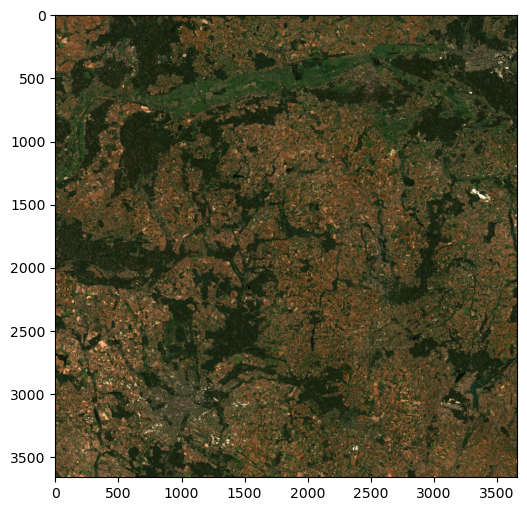

In [37]:
#| label: fig-rgb
#| fig-cap: 'RGB image of Poznan, based on HLS satellite data'

rasterio.plot.show(r[:3][::-1]*4);

When plotting a standalone array, axes breaks reflect indices---since `rasterio.plot.show` has no knowledge of array the georeferencing. To show coordinates (as in plots of raster file connections, see @sec-plotting-single-band), we can pass the `transform` matrix (@fig-rgb-w-transform):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


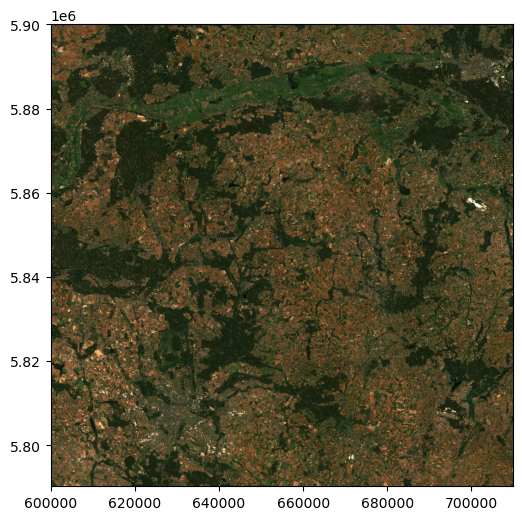

In [38]:
#| label: fig-rgb-w-transform
#| fig-cap: 'RGB image of Poznan, based on HLS satellite data, with georeferenced axes'

rasterio.plot.show(r[:3][::-1]*4, transform=src.transform);

## Masking and cropping

*Masking* a raster means "erasing" values outside an area of interest, defined by polygon(s), by turning them into "No Data". *Cropping* means that, additionally, we "shrink" the raster extent to eliminate empty rows and columns from the margins of the original extent.

In the following example, we are going to crop and mask the HLS image according the the bounding box of the Poznan airport buffered by 1 $km$.

First, let's re-create the airport polygon `pol` (@sec-subsetting-by-attributes):

In [39]:
pol = gpd.read_file('data/osm/gis_osm_transport_a_free_1.shp')
sel = 'Port Lotniczy Poznań-Ławica im. Henryka Wieniawskiego'
pol = pol[pol['name'] == sel]
pol = pol.to_crs(src.crs)
pol

,osm_id,code,fclass,name,geometry
116,342024881,5651,airport,Port Lotniczy Poznań-Ławica im. Henryka Wienia...,"POLYGON ((622419.265 5809827.499, 622431.793 5..."


Next, we use the `.buffer` (@sec-buffers) method to create a buffer of 1 $km$. We then take the bounding box of the buffer using the [`.envelope`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.envelope.html) property:

In [40]:
bbox = pol.buffer(1000).envelope
bbox

116    POLYGON ((621419.373 5807636.677, 627127.920 5...
dtype: geometry

Here is an intractive view of the `pol` and `bbox` geometries:

In [41]:
m = bbox.explore()
pol.explore(m=m, color='red')

The [`rasterio.mask.mask`](https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html#masking-a-raster-using-a-shapefile) function can be used for masking (and possibly cropping). It accepts the following arguments:

* `dataset`—A raster file connection (e.g., `src`)
* `shapes`—A list of `shapely` polygons (e.g., `bbox.to_list()`)
* `crop`—Whether to also reduce (i.e., crop) the raster extent according to the extent of `shapes`
* `nodata`—Value to use for "No Data". Typically:
    * a specific value (e.g., `-9999`) for `int` rasters, or 
    * `np.nan` for `float` rasters.

For example, here is how we can mask and crop the HLS image according to the `bbox` polygon(s):

In [42]:
out_image, out_transform = rasterio.mask.mask(
    src, 
    bbox.to_list(), 
    crop=True, 
    nodata=-9999
)

Note that `rasterio.mask.mask` returns a `tuple`, which we immediately ["unpack"](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences) into two variables, `out_image`:

In [43]:
out_image

array([[[-9999,   479,   532, ...,   301,   285, -9999],
        [-9999,   296,   220, ...,   379,   290, -9999],
        [-9999,   836,   244, ...,   355,   276, -9999],
        ...,
        [-9999,   342,   531, ...,   242,   330, -9999],
        [-9999,   247,   458, ...,   414,   313, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999]],

       [[-9999,   746,   848, ...,   492,   445, -9999],
        [-9999,   591,   477, ...,   594,   507, -9999],
        [-9999,  1162,   508, ...,   553,   535, -9999],
        ...,
        [-9999,   626,   820, ...,   440,   555, -9999],
        [-9999,   553,   756, ...,   684,   575, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999]],

       [[-9999,   830,   918, ...,   366,   296, -9999],
        [-9999,   577,   469, ...,   561,   351, -9999],
        [-9999,  1295,   519, ...,   564,   331, -9999],
        ...,
        [-9999,   848,   924, ...,   426,   580, -9999],
        [-9999,   576,   840, ...,   744,   5

and `out_transform`:

In [44]:
out_transform

Affine(30.0, 0.0, 621390.0,
       0.0, -30.0, 5811120.0)

Since masking operates on the file connection, while all further processing steps were done in-memory, they need to be repeated on `out_image`:

In [45]:
out_image = out_image.astype(float)
out_image[out_image == -9999] = np.nan
out_image = out_image * 0.0001
out_image[out_image < 0] = 0
out_image[out_image > 1] = 1

The processed cropped array looks as follows:

In [46]:
out_image

array([[[   nan, 0.0479, 0.0532, ..., 0.0301, 0.0285,    nan],
        [   nan, 0.0296, 0.022 , ..., 0.0379, 0.029 ,    nan],
        [   nan, 0.0836, 0.0244, ..., 0.0355, 0.0276,    nan],
        ...,
        [   nan, 0.0342, 0.0531, ..., 0.0242, 0.033 ,    nan],
        [   nan, 0.0247, 0.0458, ..., 0.0414, 0.0313,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[   nan, 0.0746, 0.0848, ..., 0.0492, 0.0445,    nan],
        [   nan, 0.0591, 0.0477, ..., 0.0594, 0.0507,    nan],
        [   nan, 0.1162, 0.0508, ..., 0.0553, 0.0535,    nan],
        ...,
        [   nan, 0.0626, 0.082 , ..., 0.044 , 0.0555,    nan],
        [   nan, 0.0553, 0.0756, ..., 0.0684, 0.0575,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[   nan, 0.083 , 0.0918, ..., 0.0366, 0.0296,    nan],
        [   nan, 0.0577, 0.0469, ..., 0.0561, 0.0351,    nan],
        [   nan, 0.1295, 0.0519, ..., 0.0564, 0.0331,    nan],
        ...,
        [   

Note that the dimensions are now smaller:

In [47]:
out_image.shape

(4, 117, 192)

Here is a plot of the cropped image and the airport boundary (which is also an example of displaying a vector layer on top of a raster):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\ProgramData\miniconda3\Lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


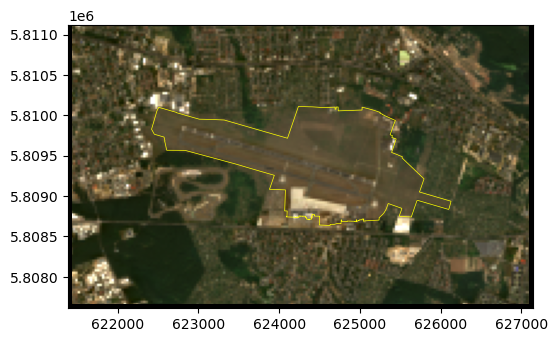

In [48]:
#| label: fig-rgb-airport
#| fig-cap: 'Cropped RGB image of Poznan (airport), based on HLS satellite data'

fig, ax = plt.subplots()
rasterio.plot.show(out_image[0:3][::-1]*4, transform=out_transform, ax=ax)
pol.plot(ax=ax, edgecolor='yellow', linewidth=0.5, color='none');

If necessary, here is how we can export the airport raster to a file named `airport.tif`:

In [49]:
meta.update(dtype=out_image.dtype)
meta.update(transform=out_transform)
meta.update(width=out_image.shape[2])
meta.update(height=out_image.shape[1])
dst = rasterio.open('airport.tif', 'w', **meta)
dst.write(out_image)
dst.close()

## More information

See the [Python Quickstart](https://rasterio.readthedocs.io/en/latest/quickstart.html) tutorial (@fig-docs-rasterio), and other sections in the `rasterio` [documentation](https://rasterio.readthedocs.io/en/latest/topics/index.html), for more information about `rasterio`.

![The [Python Quickstart](https://rasterio.readthedocs.io/en/latest/quickstart.html) tutorial](images/docs_rasterio.png){#fig-docs-rasterio}